# Differences in Energy Reconstructions
### script to visualize geometry-dependent reconstruction differences 

In [5]:
from icecube import dataio, dataclasses
from icecube import icetray
from icecube.weighting.weighting import from_simprod, NeutrinoGenerator, GenerationProbability
import numpy as np
from scipy.optimize import curve_fit
import scipy.stats
import matplotlib
matplotlib.use('agg') #otherwise get an Tkinter import error... maybe use different environment.
import matplotlib.pyplot as plt
import os
import glob
import argparse
import matplotlib.cbook as cbook 
import matplotlib.colors as colors 
plt.style.use(r"~/.config/matplotlib/stylelib/latex.mplstyle")
import pandas as pd
#import Segmented_Muon_Energy_jstettner as sme
import imp
rana = imp.load_source('philipps_module', '/home/pfuerst/master_thesis/software/reco_analysis/reco_analysis_methods.py')
myplt = imp.load_source('myplot', '/home/pfuerst/master_thesis/software/matplotlib_tools/myplot.py')
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [6]:
def get_pickles(*args):
    """returns pickles containing *args in their globstring, fixing all energy dims to GeV.
    Can be used to read in single files, if several *args are given, automatically combines the pandas dataframes.
    """
    new_pickles = sorted(glob.glob("/data/user/pfuerst/Reco_Analysis/systematic_sets_2019/*.pickle"))
    to_open = []
    dataframes = []
    for arg in args:
        for new_pickle in new_pickles:
            counter = 0
            if arg in str(new_pickle):
                counter +=1
                to_open.append(new_pickle)
            if counter > 1:
                print("several files match arg {}.".format(arg))
    for file in to_open:
        dataframes.append(pd.read_pickle(file))
        
    full = pd.concat(dataframes)
    return full

In [7]:
BDT_results = get_pickles("21124", "21002")

In [8]:
#read pickle file with BDT prediction on 21002+21124 datasets.
#BDT_results = pd.read_pickle("/data/user/pfuerst/Reco_Analysis/Simulated_Energies_Lists/feature_dataframes/2019_frames/21002+21124/full_2019_wXY.pickle")
spacials_dir = "/home/pfuerst/master_thesis/plots/reco_analysis/2019/spacial_deviations"
savepath = "/home/pfuerst/master_thesis/plots/combienergy_plots/testplots/"
directory = os.path.dirname(savepath)
if not os.path.exists(directory):
    os.makedirs(directory)

BDT_results.keys()

Index(['cog_rho', 'cog_z', 'lseparation', 'nch', 'bayes_llh_diff',
       'cos_zenith', 'rlogl', 'ldir_c', 'ndir_c', 'sigma_paraboloid', 'sdir_e',
       'E_truncated', 'E_muex', 'E_dnn', 'random_variable', 'E_entry',
       'E_exit', 'OneWeight', 'NEvent', 'TIntProbW', 'MCPrimaryEnergy',
       'MCPrimaryType', 'MCPrimaryCosZen', 'cog_x', 'cog_y', 'E_predicted',
       'mean_x', 'mean_y', 'mean_z', 'mean_r'],
      dtype='object')

## Energy Reconstruction Resolutions

In [9]:
muon_entry_energy     = BDT_results["E_entry"] #these are not in log
truncated_energy      = 10**BDT_results["E_truncated"]
muex_energy           = 10**BDT_results["E_muex"]
dnn_energy            = 10**BDT_results["E_dnn"]
E_predicted           = BDT_results["E_predicted"]
bdt_energy            = E_predicted
variable_dataframe    = BDT_results.drop(columns = ["E_entry","E_predicted", "MCPrimaryType"])
E_true_entry = muon_entry_energy   

In [10]:
minE, maxE = 10,1e9
print(minE, maxE)

nbins = 200
Edges = rana.create_log_bin_edges(minE, maxE, nbins)
Centers = rana.get_log_bin_centers(Edges)

#2d Histograms
HistTruncDepo = np.histogram2d(muon_entry_energy, truncated_energy, bins=(Edges, Edges))
HistMuExDepo  = np.histogram2d(muon_entry_energy, muex_energy, bins = (Edges, Edges))
HistDNNDepo = np.histogram2d(muon_entry_energy, dnn_energy, bins=(Edges, Edges))
HistBDTDepo = np.histogram2d(E_true_entry, E_predicted, bins=(Edges, Edges))

#Median and quantiles, see reco analysis module. Takes ~2 mins
MuEx_qdict = rana.median_and_quantile_along_hist2d_y_and_x(muon_entry_energy, muex_energy, Edges, Edges)
Truncated_qdict = rana.median_and_quantile_along_hist2d_y_and_x(muon_entry_energy, truncated_energy, Edges, Edges)
DNN_qdict = rana.median_and_quantile_along_hist2d_y_and_x(muon_entry_energy, dnn_energy, Edges, Edges)
BDT_qdict = rana.median_and_quantile_along_hist2d_y_and_x(E_true_entry, E_predicted, Edges, Edges)

Muex_sigma = rana.get_log_sigma_quantile(MuEx_qdict["y_upper_q"], MuEx_qdict["y_lower_q"])
Truncated_sigma = rana.get_log_sigma_quantile(Truncated_qdict["y_upper_q"], Truncated_qdict["y_lower_q"])
DNN_sigma = rana.get_log_sigma_quantile(DNN_qdict["y_upper_q"], DNN_qdict["y_lower_q"])
BDT_sigma = rana.get_log_sigma_quantile(BDT_qdict["y_upper_q"], BDT_qdict["y_lower_q"])

Muex_sigma_x = rana.get_log_sigma_quantile(MuEx_qdict["x_upper_q"], MuEx_qdict["x_lower_q"])
Truncated_sigma_x = rana.get_log_sigma_quantile(Truncated_qdict["x_upper_q"], Truncated_qdict["x_lower_q"])
DNN_sigma_x = rana.get_log_sigma_quantile(DNN_qdict["x_upper_q"], DNN_qdict["x_lower_q"])
BDT_sigma_x = rana.get_log_sigma_quantile(BDT_qdict["x_upper_q"], BDT_qdict["x_lower_q"])

10 1000000000.0


In [11]:
def text_in_plot(text,color,ax, size =12, pos1=0.9,pos2=0.1, horizontalalignment='right',verticalalignment='center'):
    """puts 'text' at relative position (x=pos1,y=pos2) in subplot with ax=ax.
    """
    ax.text(pos1,pos2,text,
            horizontalalignment = horizontalalignment, 
            verticalalignment = verticalalignment,
            transform=ax.transAxes,color=color,fontsize = size)
    return None

In [12]:
savepath = "/home/pfuerst/master_thesis/plots/reco_analysis/2019/notebook/"

In [13]:
matplotlib.rcParams['font.size']

10.0

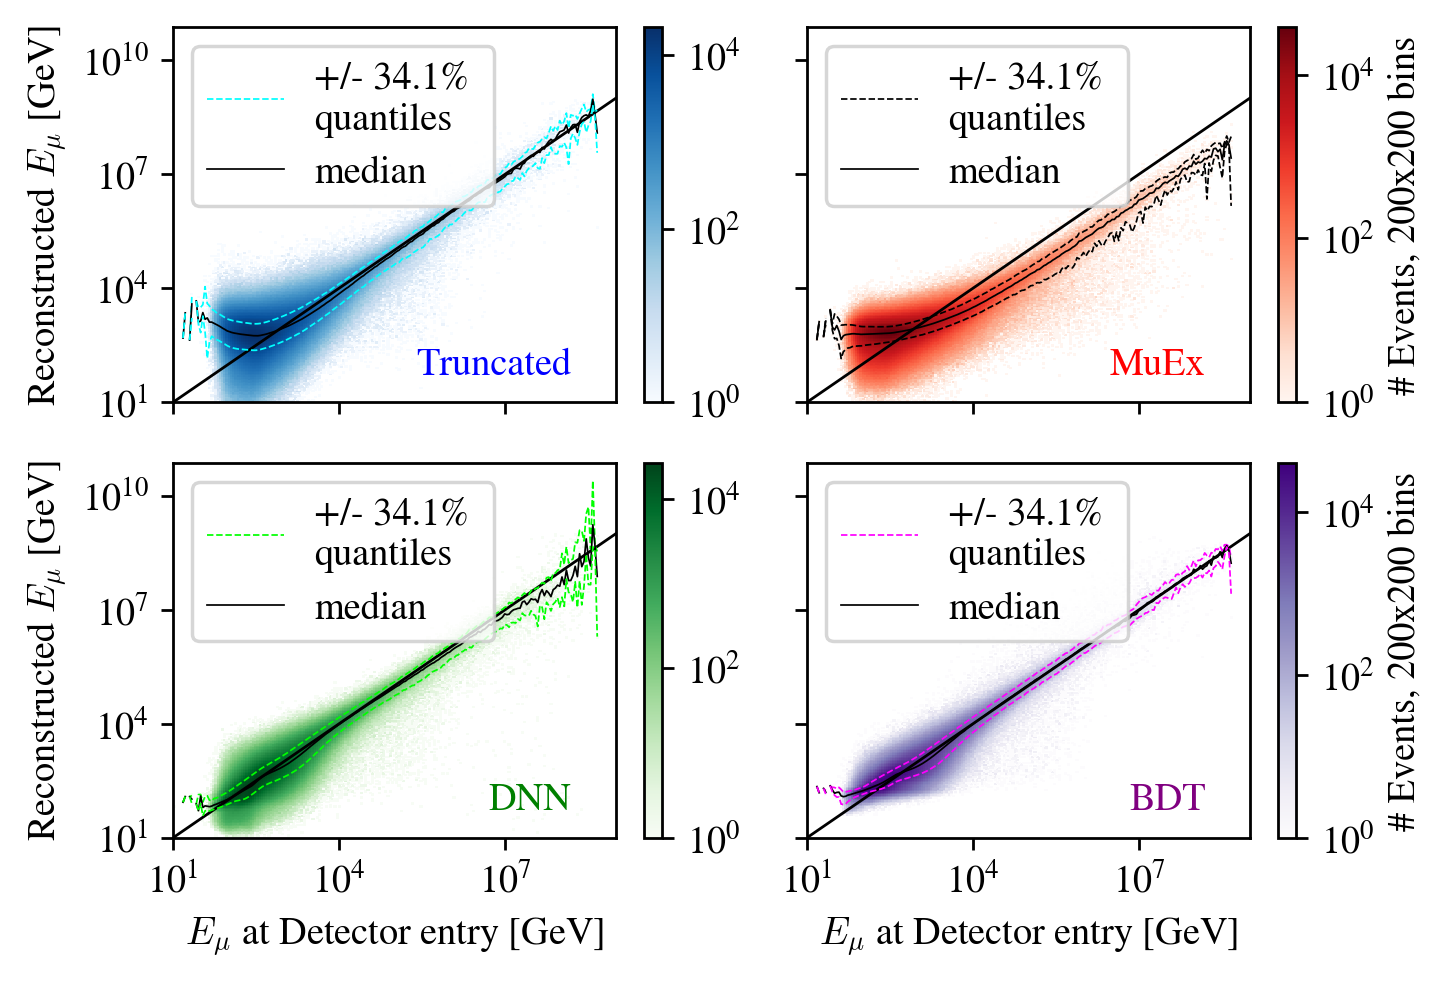

In [14]:
size = 11
l    = 0.5
legendloc = "upper left"
mysize = myplt.set_size(subplots=(2,2), ratio = "golden", squeeze_height = 1.1)
#figsize = (15,10)
fig, ((ax1, ax2), (ax3,ax4)) = plt.subplots(2,2, dpi = 250, figsize = mysize, sharex = True, sharey= True)
qtilelabel = "+/- 34.1% \nquantiles"
c1 = ax1.pcolormesh(Edges,Edges,HistTruncDepo[0].T,cmap="Blues",   norm=colors.LogNorm(vmin = 1, vmax = np.max(HistTruncDepo[0])))
cbar1 = fig.colorbar(c1,ax = ax1)
#cbar1.set_label('# Events, {}x{} bins'.format(nbins, nbins),size=size,rotation=90)
cbar1.ax.tick_params(labelsize=size)
ax1.plot(np.linspace(minE,maxE, 100),np.linspace(minE,maxE, 100),color="black",linewidth=0.8)
#ax1.text(0.1, 0.9, 'Truncated', horizontalalignment='left', verticalalignment='center', transform=ax1.transAxes,color="blue",fontsize = size)
text_in_plot('Truncated','blue',ax1,size = size)
ax1.plot(Centers,Truncated_qdict["y_upper_q"], color="cyan", linestyle = "--", linewidth = l, label=qtilelabel)
ax1.plot(Centers,Truncated_qdict["y_median"],  color="black",                linewidth = l, label = "median")
ax1.plot(Centers,Truncated_qdict["y_lower_q"], color="cyan", linestyle = "--", linewidth = l)
ax1.set_xscale("log")
ax1.set_yscale("log")
plt.setp(ax1.get_xticklabels(), fontsize=size)
plt.setp(ax1.get_yticklabels(), fontsize=size)
#ax1.set_xlabel("$E_{\mu}$ at Detector Entry [GeV]",fontsize = size)
ax1.set_ylabel("Reconstructed $E_{\mu}$ [GeV]",fontsize = size)
ax1.legend(loc=legendloc, fontsize = size)

c2 = ax2.pcolormesh(Edges,Edges,HistMuExDepo[0].T,cmap="Reds", norm=colors.LogNorm(vmin = 1, vmax = np.max(HistMuExDepo[0])))
#ax2.text(0.1, 0.9, 'MuEx', horizontalalignment='left', verticalalignment='center', transform=ax2.transAxes,color="red",fontsize = size)
text_in_plot('MuEx','red',ax2,size = size)
ax2.plot(Centers,MuEx_qdict["y_upper_q"], color="black", linestyle = "--", linewidth = l, label=qtilelabel)
ax2.plot(Centers,MuEx_qdict["y_median"],  color="black",                   linewidth = l, label = "median")
ax2.plot(Centers,MuEx_qdict["y_lower_q"], color="black", linestyle = "--", linewidth = l)
ax2.set_xscale("log")
ax2.set_yscale("log")
plt.setp(ax2.get_xticklabels(), fontsize=size)
plt.setp(ax2.get_yticklabels(), fontsize=size)
ax2.plot(np.linspace(minE,maxE, 100),np.linspace(minE,maxE, 100),color="black", linewidth = 0.8)
cbar2 = fig.colorbar(c2,ax = ax2)
cbar2.set_label('# Events, {}x{} bins'.format(nbins, nbins),size=size,rotation=90)
cbar2.ax.tick_params(labelsize=size)
#ax2.set_xlabel("$E_{\mu}$ at Detector Entry [GeV]", fontsize = size)
#ax2.set_ylabel("Reconstructed $E_{\mu}$ [GeV]",fontsize = size)
ax2.legend(loc=legendloc, fontsize = size)

c3 = ax3.pcolormesh(Edges,Edges,HistDNNDepo[0].T,cmap="Greens", norm=colors.LogNorm(vmin = 1, vmax = np.max(HistDNNDepo[0])))
#ax3.text(0.1, 0.9, 'DNN', horizontalalignment='left', verticalalignment='center', transform=ax3.transAxes,color="green",fontsize = size)
text_in_plot('DNN','green',ax3,size = size)

ax3.set_xscale("log")
ax3.set_yscale("log")
plt.setp(ax3.get_xticklabels(), fontsize=size)
plt.setp(ax3.get_yticklabels(), fontsize=size)
ax3.plot(np.linspace(minE,maxE, 100),np.linspace(minE,maxE, 100),color="black", linewidth = 0.8)
ax3.plot(Centers,DNN_qdict["y_upper_q"], color="lime", linestyle = "--", linewidth = l, label=qtilelabel)
ax3.plot(Centers,DNN_qdict["y_median"],  color="black",                   linewidth = l, label = "median")
ax3.plot(Centers,DNN_qdict["y_lower_q"], color="lime", linestyle = "--", linewidth = l)
cbar3 = fig.colorbar(c3,ax = ax3)
#cbar3.set_label('# Events, {}x{} bins'.format(nbins, nbins),size=size,rotation=90)
cbar3.ax.tick_params(labelsize=size)
ax3.set_xlabel("$E_{\mu}$ at Detector entry [GeV]", fontsize = size)
ax3.set_ylabel("Reconstructed $E_{\mu}$ [GeV]",fontsize = size)
ax3.legend(loc=legendloc, fontsize = size)

c4 = ax4.pcolormesh(Edges,Edges,HistBDTDepo[0].T,cmap="Purples", norm=colors.LogNorm(vmin = 1, vmax = np.max(HistBDTDepo[0])))
ax4.set_xscale("log")
ax4.set_yscale("log")
#ax4.text(0.1, 0.9, 'BDT', horizontalalignment='left', verticalalignment='center', transform=ax4.transAxes,color="purple",fontsize = size)
text_in_plot('BDT','purple',ax4,size = size)

plt.setp(ax4.get_xticklabels(), fontsize=size)
plt.setp(ax4.get_yticklabels(), fontsize=size)
ax4.plot(np.linspace(minE,maxE, 100),np.linspace(minE,maxE, 100),color="black", linewidth = 0.8)
ax4.plot(Centers,BDT_qdict["y_upper_q"], color="magenta", linestyle = "--", linewidth = l, label=qtilelabel)
ax4.plot(Centers,BDT_qdict["y_median"],  color="black",                   linewidth = l, label = "median")
ax4.plot(Centers,BDT_qdict["y_lower_q"], color="magenta", linestyle = "--", linewidth = l)
cbar4 = fig.colorbar(c4,ax = ax4)
cbar4.set_label('# Events, {}x{} bins'.format(nbins, nbins),size=size,rotation=90)
cbar4.ax.tick_params(labelsize=size)
ax4.set_xlabel("$E_{\mu}$ at Detector entry [GeV]", fontsize = size)
#ax4.set_ylabel("Reconstructed $E_{\mu}$ [GeV]",fontsize = size)
ax4.legend(loc=legendloc, fontsize = size)
plt.tight_layout()

#plt.savefig(savepath+"combienergy_Hist2d_reco_comparison.png")

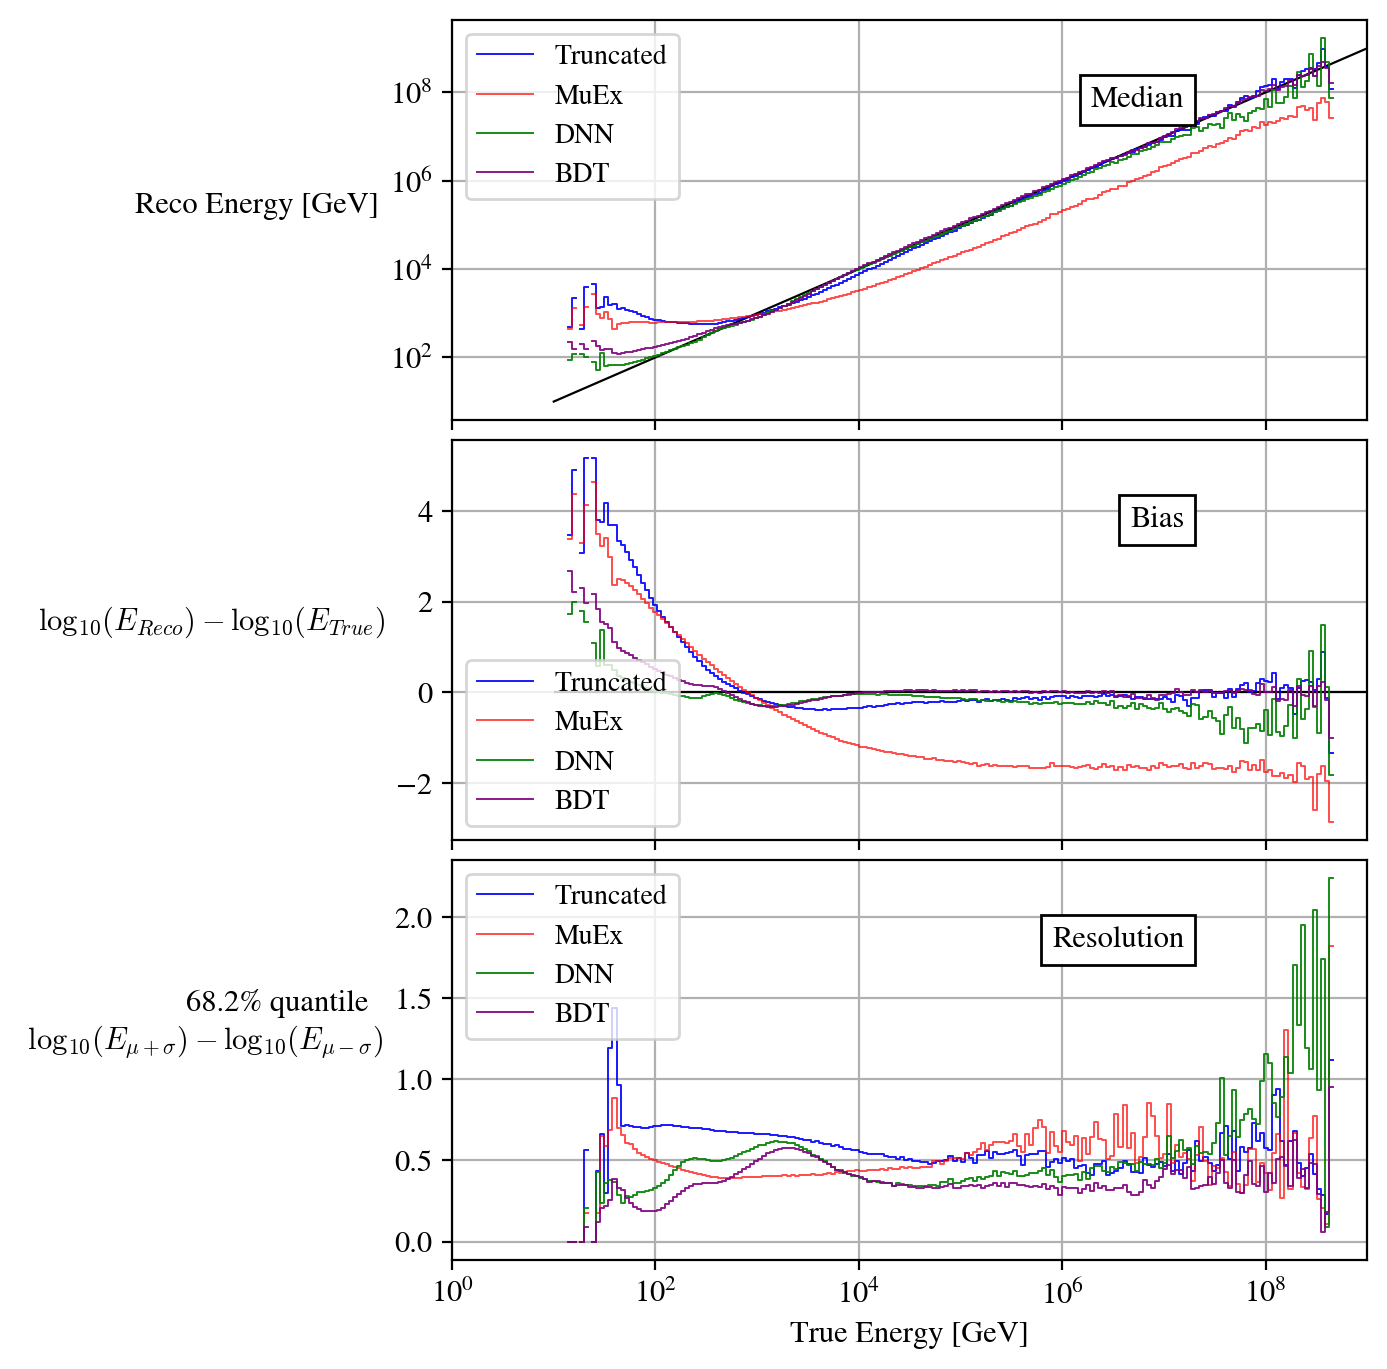

In [15]:
################################################################
#plot medians and std in y
size = 11
l = 0.7
mysize = myplt.set_size(subplots=(3,1), ratio = "golden", squeeze_height = 0.75)

fig, (ax1, ax2, ax3) = plt.subplots(3,1, sharex=True, dpi = 200, figsize = mysize) #(9,6)
xlow = 1
xhigh = 1e9
ax1.plot(np.linspace(minE,maxE, 100),np.linspace(minE,maxE, 100),color="black",linewidth = 0.8)

#truncated
ax1.step(Centers, Truncated_qdict["y_median"],
         color="blue", label ="Truncated", alpha = 0.9, linewidth = l)

#muex
ax1.step(Centers, MuEx_qdict["y_median"],
         color="red", label ="MuEx", alpha = 0.7, linewidth = l)

#dnn
ax1.step(Centers, DNN_qdict["y_median"],
         color="green", label ="DNN", alpha = 0.9, linewidth = l)

#bdt
ax1.step(Centers, BDT_qdict["y_median"],
         color="purple", label ="BDT", alpha = 0.9, linewidth = l)
t = ax1.text(0.8, 0.8, 'Median', horizontalalignment='right', verticalalignment='center', transform=ax1.transAxes,color="black",fontsize = size)
t.set_bbox(dict(facecolor='white', alpha=1, edgecolor='black'))

ax1.set_yscale("log")
ax1.set_xscale("log")
ax1.set_ylabel("Reco Energy [GeV]",fontsize = size, 
               rotation = 0, horizontalalignment = "right")
ax1.legend(loc="upper left")
ax1.grid()
ax1.set_xlim(xlow,xhigh)
plt.setp(ax1.get_yticklabels(), fontsize=size)

#plot2
ax2.step(Centers, np.log(Truncated_qdict["y_median"]) - np.log(Centers),
         color="blue",alpha=0.9, label="Truncated", linewidth = l)
ax2.step(Centers, np.log(MuEx_qdict["y_median"]) - np.log(Centers),
         color="red",alpha=0.7, label="MuEx", linewidth = l)
ax2.step(Centers, np.log(DNN_qdict["y_median"]) - np.log(Centers),
         color="green",alpha=0.9, label="DNN", linewidth = l)
ax2.step(Centers, np.log(BDT_qdict["y_median"]) - np.log(Centers),
         color="purple",alpha=0.9, label="BDT", linewidth = l)
ax2.hlines(0,minE,maxE,color="black",linewidth=0.8)
#ax2.set_yscale("log")
ax2.set_xscale("log")
ax2.set_ylabel("$\log_{10}(E_{Reco})- \log_{10}(E_{True})$",fontsize = size,
               rotation = 0, horizontalalignment = "right")
ax2.legend(loc="lower left")
ax2.grid()
plt.setp(ax2.get_yticklabels(), fontsize=size)


t = ax2.text(0.8, 0.8, 'Bias', horizontalalignment='right', verticalalignment='center', transform=ax2.transAxes,color="black",fontsize = size)
t.set_bbox(dict(facecolor='white', alpha=1, edgecolor='black'))

#if this is one, the absolute spread is on the order of the true energy
ax3.step(Centers, Truncated_sigma, color="blue", label = "Truncated",    alpha=0.9, linewidth = l)
ax3.step(Centers, Muex_sigma,      color="red", label = "MuEx",          alpha=0.7, linewidth = l)
ax3.step(Centers, DNN_sigma,       color="green",   label = "DNN",       alpha=0.9, linewidth = l)
ax3.step(Centers, BDT_sigma,       color="purple",  label = "BDT",       alpha=0.9, linewidth = l)

#ax3.set_yscale("log")
ax3.set_xscale("log")
ax3.set_xlabel("True Energy [GeV]", fontsize = size)
ax3.set_ylabel("68.2% quantile  \n $\log_{10} (E_{\mu+ \sigma}) - \log_{10} (E_{\mu-\sigma})$", fontsize = size, 
               rotation = 0, horizontalalignment = "right")
ax3.legend(loc="upper left")
plt.setp(ax3.get_yticklabels(), fontsize=size)
plt.setp(ax3.get_xticklabels(), fontsize=size)
plt.subplots_adjust(wspace=0, hspace=0.05)
ax3.grid()

t = ax3.text(0.8, 0.8, 'Resolution', horizontalalignment='right', verticalalignment='center', transform=ax3.transAxes,color="black",fontsize = size)
t.set_bbox(dict(facecolor='white', alpha=1, edgecolor='black'))

#plt.savefig(savepath+"combienergy_resolutions_reco_comparison.png")

## Systematic Energy variations for different Reconstructions

In [29]:
#remove NaN entries from data for better plotting (e.g if E_entry calculation failed)
clean_BDT_results = BDT_results.dropna()

### In the detector

In [117]:
#some functions to plot string positions and for formatting
def get_string_xy(GCDpath):
    GCD_file = dataio.I3File(GCDpath)
    GCD_file.rewind()
    G_frame = GCD_file.pop_frame()
    omgeo = G_frame.Get("I3Geometry").omgeo

    x = []
    y = []
    for i in range(1,79):
        x.append(omgeo[icetray.OMKey(i,1,0)].position.x)
        y.append(omgeo[icetray.OMKey(i,1,0)].position.y)
    return x,y

def get_string_r(x,y):
    x = np.array(x)
    y = np.array(y)
    return np.sqrt(x**2+y**2)

def get_deepcorestring_xy(GCDpath):
    GCD_file = dataio.I3File(GCDpath)
    GCD_file.rewind()
    G_frame = GCD_file.pop_frame()
    omgeo = G_frame.Get("I3Geometry").omgeo
    x = []
    y = []
    for i in [79,80,81,82,83,84,85,86]:
        x.append(omgeo[icetray.OMKey(i,1,0)].position.x)
        y.append(omgeo[icetray.OMKey(i,1,0)].position.y)
    return x,y

def dev_cbarlabel(reco):
    """reco is a string"""
    return ("$<\log_{10}(E_{"+reco+"}) - \log_{10}(E_{entry})>$")

def geometry_template_plot(x1,y1,hist1,lbar1,x2,y2,hist2,lbar2,save,cmap="Blues",dpi = 200,
                           norm_to_zero = False, plotstrings = True,str_color = "red"):
    """x,y,hist: edges, edges, np.histogram2d[0]
    lbar: label of cbar
    norm_to_zero: use with PuOr to set 0 to white
    """
    p = 2.5
    #figsize = (10,3.7)
    figsize = myplt.set_size(subplots=(1,2), ratio="golden", squeeze_height = 1.2)
    fig, (ax1,ax2) = plt.subplots(1,2,dpi = dpi, figsize = figsize)
    if norm_to_zero == False:
        divnorm = None
    else:
        divnorm = colors.DivergingNorm(vcenter=0)
    c1 = ax1.pcolormesh(x1,y1,hist1.T,cmap = cmap, norm = divnorm)

    cbar1 = plt.colorbar(c1, ax = ax1)
    cbar1.set_label(lbar1,rotation=90)
    ax1.set_xlabel("CoG radius [m]")
    ax1.set_ylabel("CoG height [m]")
    #ax1.vlines(string_r, ymin = min(y1), ymax = max(y1), color="red", linewidth = 0.3, alpha = 0.3)
    
    if norm_to_zero == False:
        divnorm2 = None
    else:
        divnorm2 = colors.DivergingNorm(vcenter=0)
    c2 = ax2.pcolormesh(x2, y2, hist2.T, cmap = cmap, norm = divnorm2)
    cbar2 = plt.colorbar(c2)
    cbar2.set_label(lbar2,rotation=90)
    if plotstrings == True:
        ax2.plot(string_x, string_y, linestyle = "None", marker = ".", markersize = p, color=str_color, label = "Strings")
    ax2.plot(dcstring_x, dcstring_y, linestyle = "None", marker = "x",markersize = p, color = "grey")
    ax2.legend(fontsize = 9)
    ax2.set_xlabel("X [m]")
    ax2.set_ylabel("Y [m]")
    ax2.set_ylim(-550,800)#660
    plt.tight_layout()
    if not save.endswith(".png"):
        save+".png"
    plt.savefig(os.path.join(spacials_dir,save))
    return None

In [31]:
Redges = rana.create_linear_bin_edges(0,600,60)
Zedges = rana.create_linear_bin_edges(-500,+500,50)

In [32]:
#(radius, z) histograms of deviations
truncated_E_hist = np.histogram2d(clean_BDT_results["cog_rho"],clean_BDT_results["cog_z"],weights = clean_BDT_results["E_truncated"],bins = (Redges,Zedges))
trunc_deviations = clean_BDT_results["E_truncated"] - np.log10(clean_BDT_results["E_entry"])
truncated_deviations_hist = np.histogram2d(clean_BDT_results["cog_rho"],clean_BDT_results["cog_z"],
                                           weights = trunc_deviations,
                                           bins = (Redges,Zedges))

bdt_E_hist = np.histogram2d(clean_BDT_results["cog_rho"],clean_BDT_results["cog_z"],weights = np.log10(clean_BDT_results["E_predicted"]),bins = (Redges,Zedges))
bdt_devs = np.log10(clean_BDT_results["E_predicted"]) - np.log10(clean_BDT_results["E_entry"])
bdt_deviations_hist = np.histogram2d(clean_BDT_results["cog_rho"],clean_BDT_results["cog_z"],
                                           weights = bdt_devs,
                                           bins = (Redges,Zedges))

dnn_E_hist = np.histogram2d(clean_BDT_results["cog_rho"],clean_BDT_results["cog_z"],weights = clean_BDT_results["E_dnn"],bins = (Redges,Zedges))
dnn_devs = clean_BDT_results["E_dnn"] - np.log10(clean_BDT_results["E_entry"])
dnn_deviations_hist = np.histogram2d(clean_BDT_results["cog_rho"],clean_BDT_results["cog_z"],
                                           weights = dnn_devs,
                                           bins = (Redges,Zedges))

In [118]:
GCD_path = "/cvmfs/icecube.opensciencegrid.org/data/GCD/GeoCalibDetectorStatus_2016.57531_V0.i3.gz"
string_x, string_y = get_string_xy(GCD_path)
string_r = get_string_r(string_x,string_y)
dcstring_x, dcstring_y = get_deepcorestring_xy(GCD_path)
x_edges = np.linspace(-600,600,80)
y_edges = np.linspace(-550,550,80)

#(x, y) histograms of deviations
xy_map_counts = np.histogram2d(clean_BDT_results["cog_x"], clean_BDT_results["cog_y"], bins = (x_edges, y_edges))

#truncated fails
xy_map_truncfail = np.histogram2d(truncfailed["cog_x"], truncfailed["cog_y"], bins = (x_edges, y_edges))

#truncated deviations
trunc_deviations = clean_BDT_results["E_truncated"] - np.log10(clean_BDT_results["E_entry"])
xy_map_trunc_devs = np.histogram2d(clean_BDT_results["cog_x"], clean_BDT_results["cog_y"],
                                   weights = trunc_deviations,bins = (x_edges, y_edges))

#dnn deviations
dnn_deviations = clean_BDT_results["E_dnn"] - np.log10(clean_BDT_results["E_entry"])
xy_map_dnn_devs = np.histogram2d(clean_BDT_results["cog_x"], clean_BDT_results["cog_y"],
                                   weights = dnn_deviations,bins = (x_edges, y_edges))

#bdt deviations
bdt_deviations = np.log10(clean_BDT_results["E_predicted"]) - np.log10(clean_BDT_results["E_entry"])
xy_map_bdt_devs = np.histogram2d(clean_BDT_results["cog_x"], clean_BDT_results["cog_y"],
                                   weights = bdt_deviations,bins = (x_edges, y_edges))

In [119]:
count_hist = np.histogram2d(clean_BDT_results["cog_rho"],clean_BDT_results["cog_z"],bins = (Redges,Zedges))
#entry_E_hist = np.histogram2d(BDT_results["cog_rho"],BDT_results["cog_z"],weights = np.log10(BDT_results["E_entry"]),bins = (Redges,Zedges))

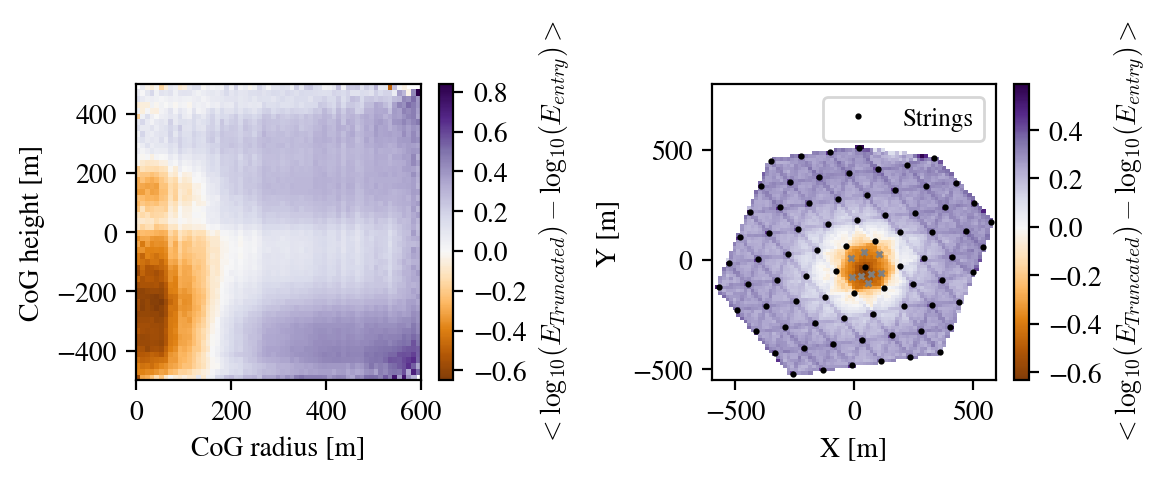

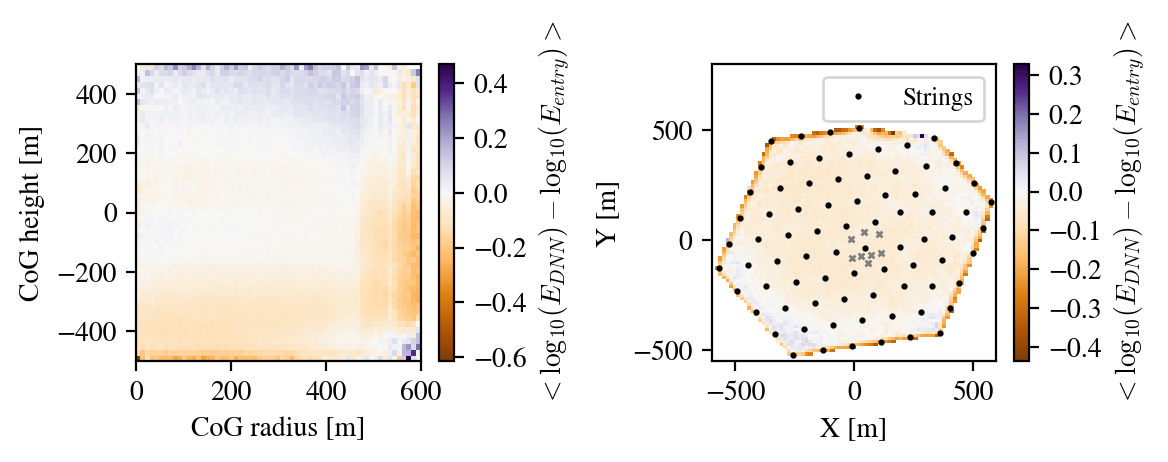

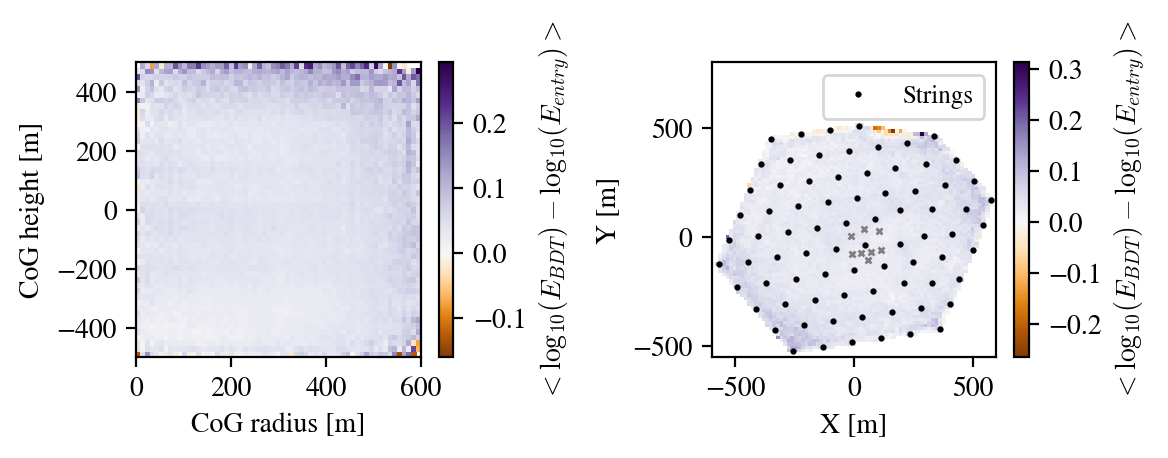

In [120]:
clabel = dev_cbarlabel("Truncated")
geometry_template_plot(Redges,Zedges,(truncated_deviations_hist[0]/count_hist[0]),clabel,
                      x_edges, y_edges, (xy_map_trunc_devs[0]/xy_map_counts[0]),clabel, 
                       "trunc_devs.png",
                       cmap = "PuOr",str_color="black", norm_to_zero = True)

clabel = dev_cbarlabel("DNN")
geometry_template_plot(Redges,Zedges,(dnn_deviations_hist[0]/count_hist[0]),clabel,
                      x_edges, y_edges, (xy_map_dnn_devs[0]/xy_map_counts[0]),clabel, 
                       "dnn_devs.png",
                       cmap = "PuOr",str_color="black", norm_to_zero = True)

clabel = dev_cbarlabel("BDT")
geometry_template_plot(Redges,Zedges,(bdt_deviations_hist[0]/count_hist[0]),clabel,
                      x_edges, y_edges, (xy_map_bdt_devs[0]/xy_map_counts[0]),clabel, 
                       "bdt_devs",
                       cmap = "PuOr",str_color="black", norm_to_zero = True)

### across all topological variables

In [51]:
print("pick one of the BDT input features from this list in the next cell. sigma_paraboloid, cogx/y are not used for training.")
BDT_results.keys()

pick one of the BDT input features from this list in the next cell. sigma_paraboloid, cogx/y are not used for training.


Index(['E_dnn', 'E_entry', 'E_exit', 'E_muex', 'E_predicted', 'E_truncated',
       'MCPrimaryCosZen', 'MCPrimaryEnergy', 'MCPrimaryType', 'NEvent',
       'OneWeight', 'TIntProbW', 'bayes_llh_diff', 'cog_rho', 'cog_x', 'cog_y',
       'cog_z', 'cos_zenith', 'ldir_c', 'lseparation', 'nch', 'ndir_c',
       'random_variable', 'rlogl', 'sdir_e', 'sigma_paraboloid'],
      dtype='object')

In [52]:
key = "cog_rho"

In [53]:
n_bins_key = 30
n_bins_energy = 50

trunc_log_dev = np.log10(truncated_energy) - np.log10(muon_entry_energy)
muex_log_dev  = np.log10(muex_energy)      - np.log10(muon_entry_energy)
dnn_log_dev   = np.log10(dnn_energy)       - np.log10(muon_entry_energy)
bdt_log_dev   = np.log10(bdt_energy)       - np.log10(muon_entry_energy)

log_min_dev = min([min(trunc_log_dev),min(muex_log_dev),min(dnn_log_dev), min(bdt_log_dev)])
log_max_dev = max([max(trunc_log_dev),max(muex_log_dev),max(dnn_log_dev), min(bdt_log_dev)])

log_deviation_bin_edges = rana.create_linear_bin_edges(log_min_dev,log_max_dev, n_bins_energy)
log_deviations_bin_centers = rana.get_linear_bin_centers(log_deviation_bin_edges)
quantile = 0.341

reco_names_list = ["Truncated","MuEx","TUM-DNN", "BDT"]
reco_main_colors = ["blue","red","green", "purple"]
reco_second_colors = ["cyan","orange","lime", "magenta"]

In [80]:
keys = list(BDT_results.keys())
to_remove = ["E_entry", "E_dnn", "E_exit", "E_muex", "E_predicted", "E_truncated", "MCPrimaryCosZen", "MCPrimaryEnergy", "MCPrimaryType", "NEvent", "OneWeight", "TIntProbW"]
for rm in to_remove:
    keys.remove(rm)


bayes_llh_diff
cog_rho
cog_x
cog_y
cog_z
cos_zenith
ldir_c
lseparation
nch
ndir_c
random_variable
rlogl
sdir_e
sigma_paraboloid


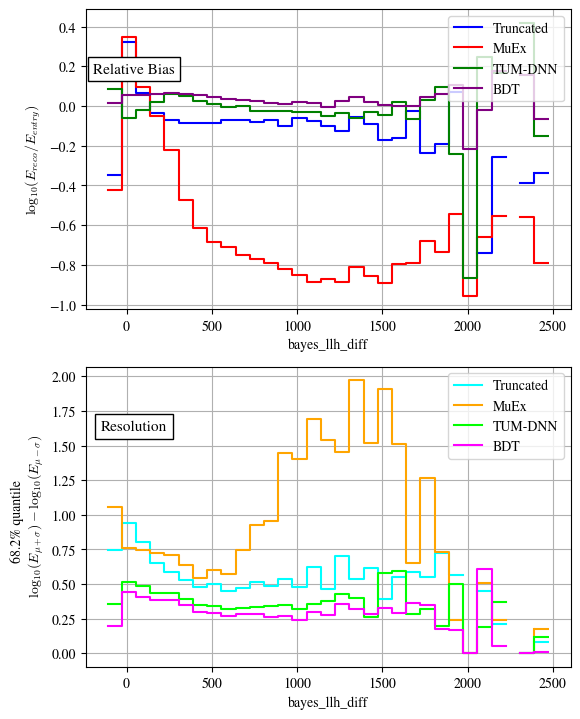

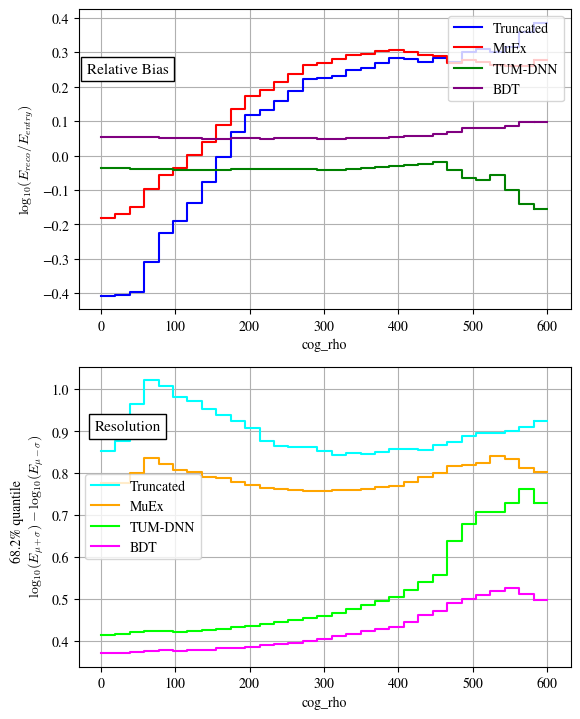

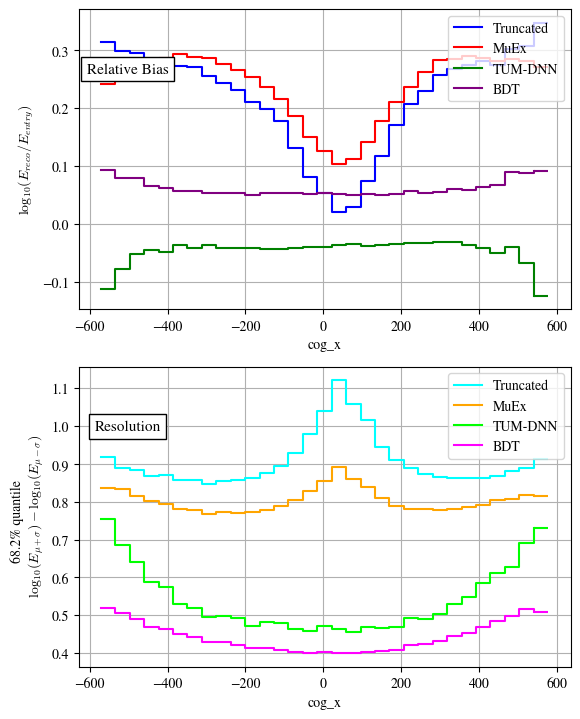

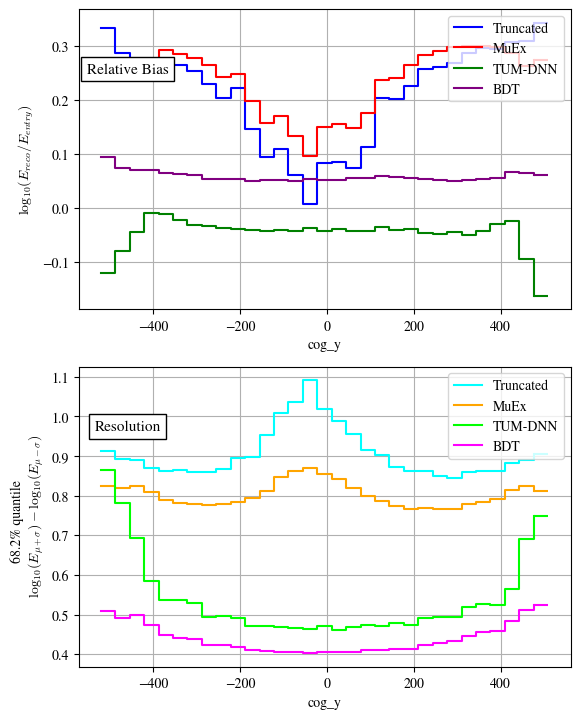

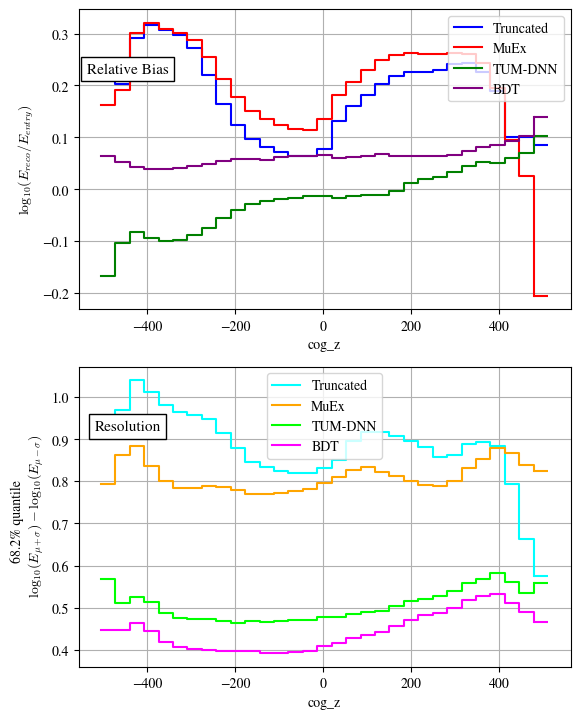

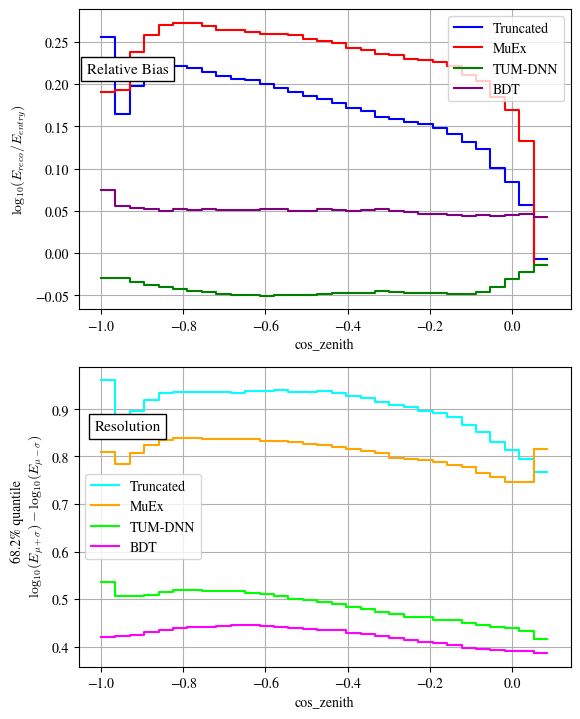

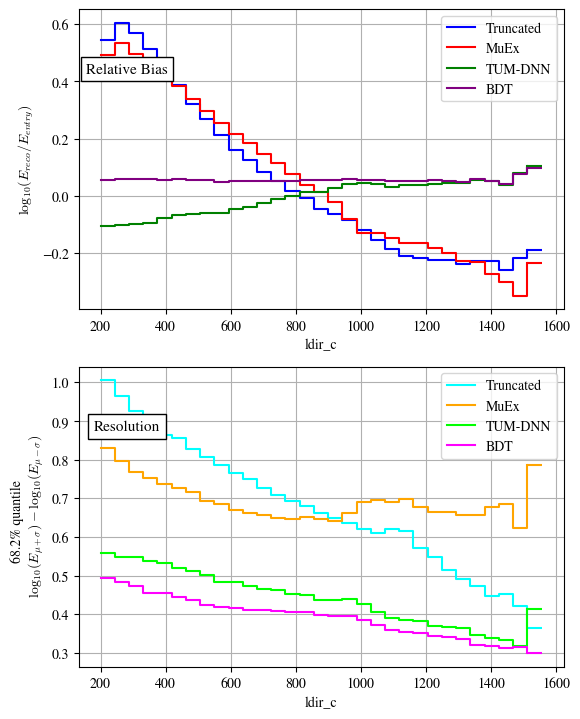

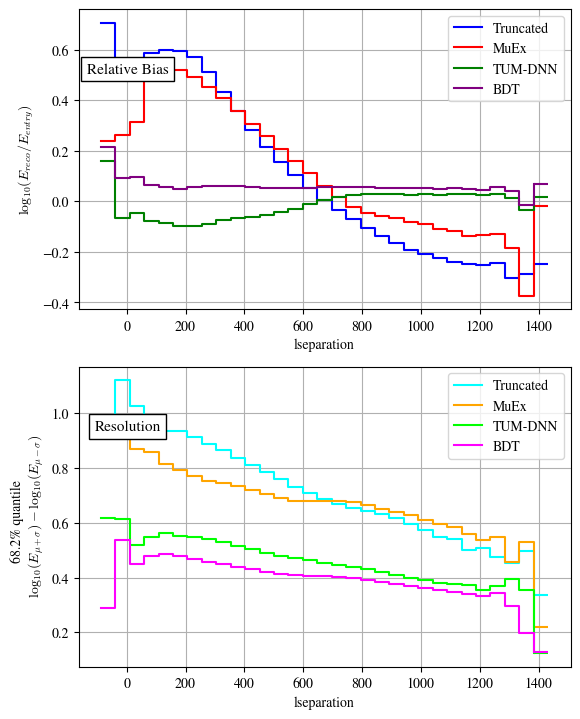

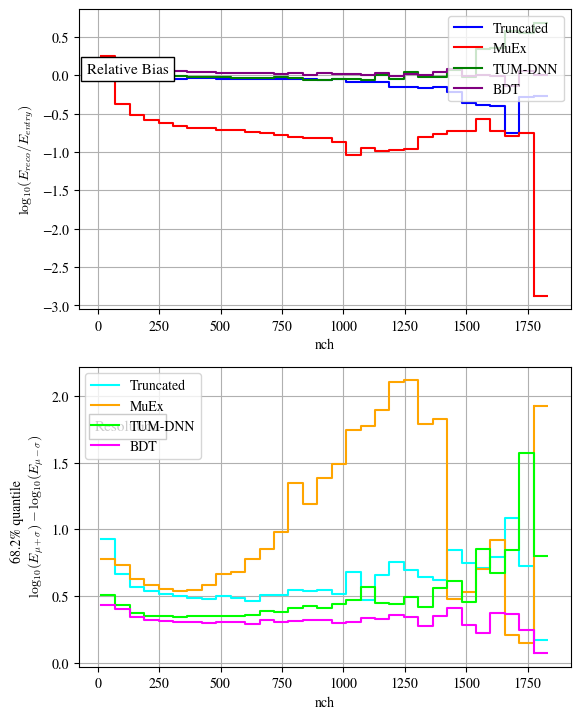

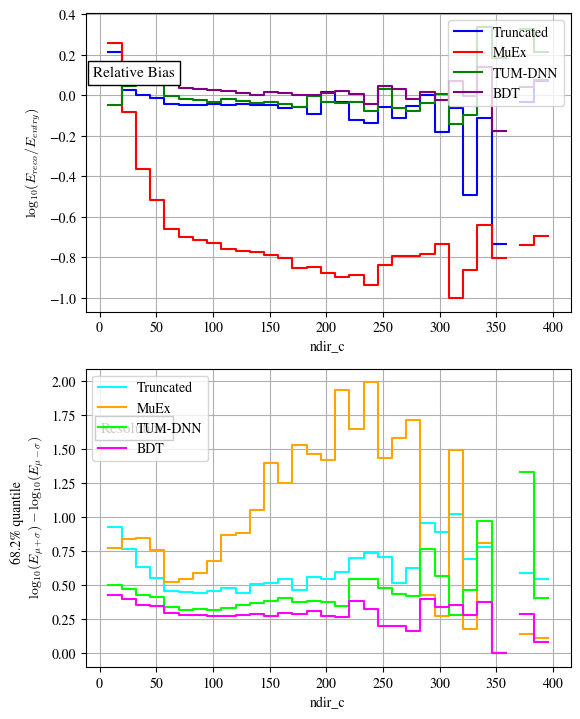

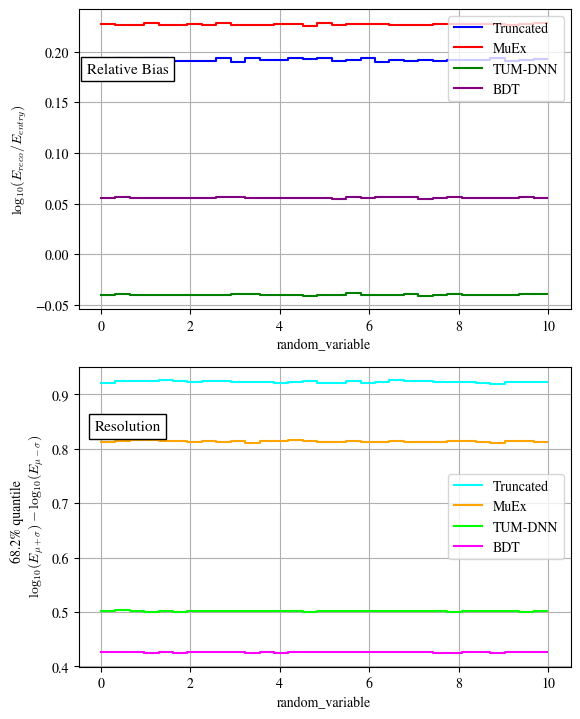

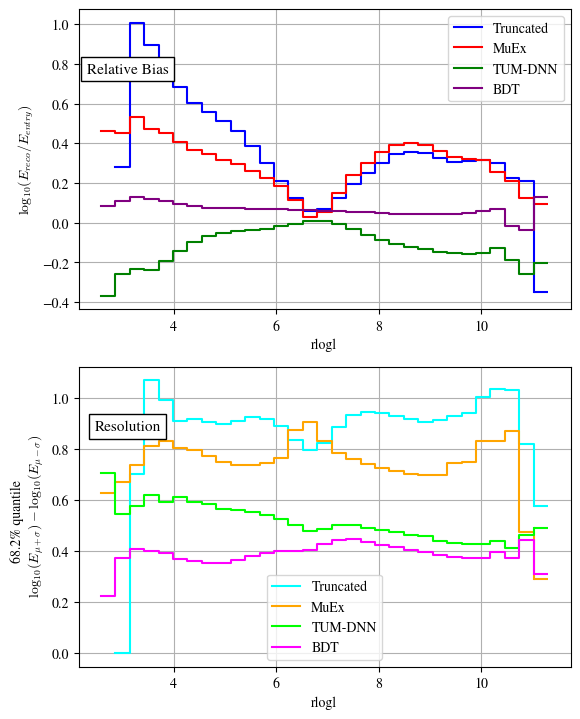

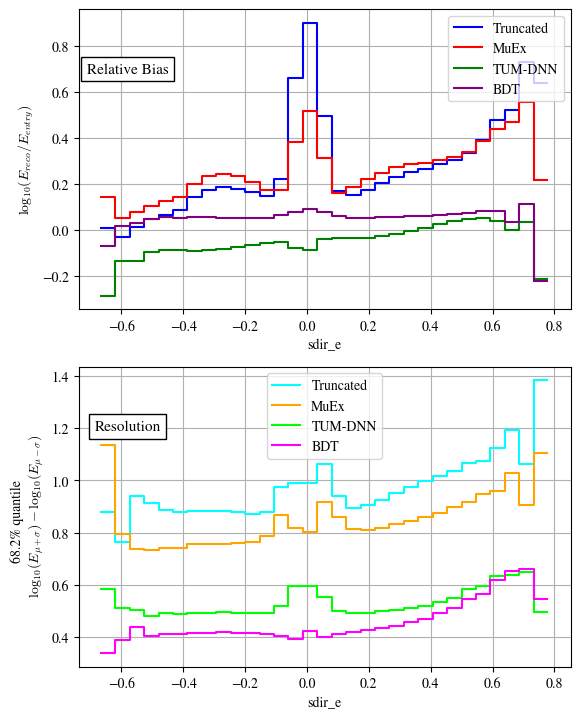

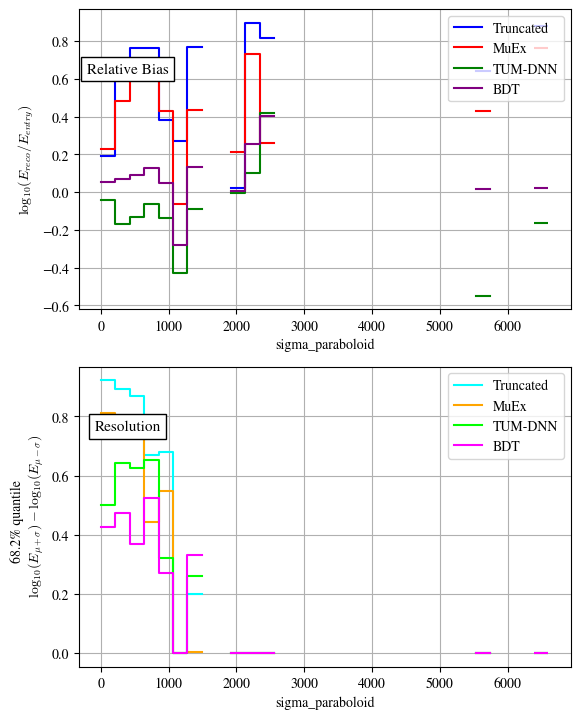

In [95]:
%matplotlib inline
for key in keys:
    print(key)
    currentlist = BDT_results[key]

    current_bin_edges = rana.create_linear_bin_edges(
        np.amin(currentlist), np.amax(currentlist), n_bins_key)

    current_bin_centers = rana.get_linear_bin_centers(current_bin_edges)
    #instead of gauss fit along hist2d
    #do median and quantiles
    truncated_dict = rana.median_and_quantile_along_hist2d_y_and_x(
        currentlist, trunc_log_dev, 
        current_bin_edges, log_deviation_bin_edges,
                                       quantile_around_median = quantile)

    muex_dict =   rana.median_and_quantile_along_hist2d_y_and_x(
        currentlist, muex_log_dev, 
        current_bin_edges, log_deviation_bin_edges,
                                       quantile_around_median = quantile)  

    dnn_dict =   rana.median_and_quantile_along_hist2d_y_and_x(
        currentlist, dnn_log_dev, 
        current_bin_edges, log_deviation_bin_edges,
                                       quantile_around_median = quantile) 

    bdt_dict =   rana.median_and_quantile_along_hist2d_y_and_x(
        currentlist, bdt_log_dev, 
        current_bin_edges, log_deviation_bin_edges,
                                       quantile_around_median = quantile) 

    reco_dict_list = [truncated_dict,muex_dict,dnn_dict, bdt_dict]


    xlabel   = key
    ylabel   = r"$\log_{10}(E_{reco}/E_{entry})$"

    figsize = myplt.set_size(subplots=(2,1), ratio="golden")
    fig, (ax1,ax2) = plt.subplots(2,1,dpi=100, figsize = figsize)
    #ax1.plot(current_bin_centers,muex_dict["y_median"])
    for idx, edict in enumerate(reco_dict_list):
        full_step(current_bin_edges,edict["y_median"], label=reco_names_list[idx], color=reco_main_colors[idx], alpha = 1, ax = ax1)
        #full_step(current_bin_edges,edict["y_upper_q"], color=reco_second_colors[idx], alpha = 1, ax = ax1)
        #full_step(current_bin_edges,edict["y_lower_q"], color=reco_second_colors[idx], alpha = 1, ax = ax1)


        full_step(current_bin_edges,edict["y_upper_q"] - edict["y_lower_q"], label=reco_names_list[idx], color=reco_second_colors[idx], alpha = 1, ax = ax2)

    ax1.grid()
    ax1.legend(loc="upper right")

    ax2.grid()
    ax2.legend()

    ax1.set_xlabel(key)
    ax2.set_xlabel(key)

    ax1.set_ylabel(r"$\log_{10}(E_{reco}/E_{entry})$")
    ax2.set_ylabel("68.2% quantile  \n $\log_{10} (E_{\mu+ \sigma}) - \log_{10} (E_{\mu-\sigma})$")

    t = ax1.text(0.1, 0.8, 'Relative Bias', horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes,color="black",fontsize = size)
    t.set_bbox(dict(facecolor='white', alpha=1, edgecolor='black'))

    t = ax2.text(0.1, 0.8, 'Resolution', horizontalalignment='center', verticalalignment='center', transform=ax2.transAxes,color="black",fontsize = size)
    t.set_bbox(dict(facecolor='white', alpha=1, edgecolor='black'))

    plt.tight_layout()
    plt.savefig(os.path.join(spacials_dir,"deviations_wBDT_golden.png"))

In [85]:
key = "cog_rho"
xlabel   = key
ylabel   = r"$\log_{10}(E_{reco}/E_{entry})$"

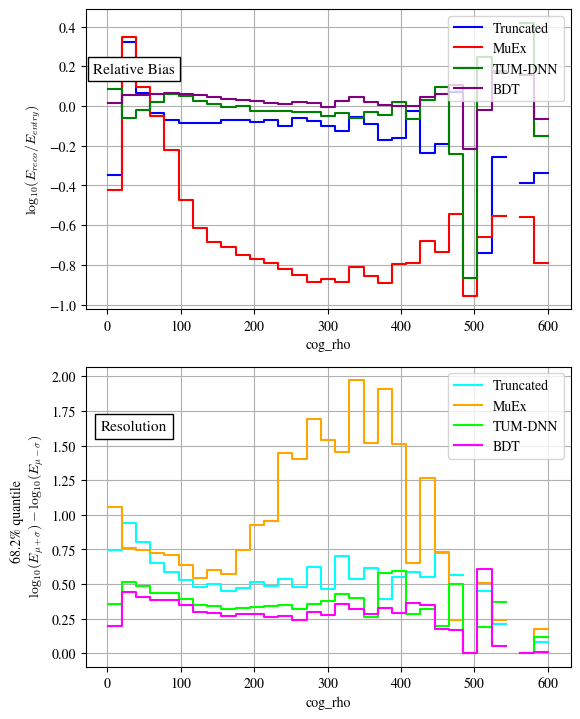

In [92]:
figsize = myplt.set_size(subplots=(2,1), ratio="golden")
fig, (ax1,ax2) = plt.subplots(2,1,dpi=100, figsize = figsize)
#ax1.plot(current_bin_centers,muex_dict["y_median"])
for idx, edict in enumerate(reco_dict_list):
    full_step(current_bin_edges,edict["y_median"], label=reco_names_list[idx], color=reco_main_colors[idx], alpha = 1, ax = ax1)
    #full_step(current_bin_edges,edict["y_upper_q"], color=reco_second_colors[idx], alpha = 1, ax = ax1)
    #full_step(current_bin_edges,edict["y_lower_q"], color=reco_second_colors[idx], alpha = 1, ax = ax1)
        
    
    full_step(current_bin_edges,edict["y_upper_q"] - edict["y_lower_q"], label=reco_names_list[idx], color=reco_second_colors[idx], alpha = 1, ax = ax2)

ax1.grid()
ax1.legend(loc="upper right")

ax2.grid()
ax2.legend()

ax1.set_xlabel(key)
ax2.set_xlabel(key)

ax1.set_ylabel(r"$\log_{10}(E_{reco}/E_{entry})$")
ax2.set_ylabel("68.2% quantile  \n $\log_{10} (E_{\mu+ \sigma}) - \log_{10} (E_{\mu-\sigma})$")

t = ax1.text(0.1, 0.8, 'Relative Bias', horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes,color="black",fontsize = size)
t.set_bbox(dict(facecolor='white', alpha=1, edgecolor='black'))

t = ax2.text(0.1, 0.8, 'Resolution', horizontalalignment='center', verticalalignment='center', transform=ax2.transAxes,color="black",fontsize = size)
t.set_bbox(dict(facecolor='white', alpha=1, edgecolor='black'))

plt.tight_layout()
#plt.savefig(os.path.join(spacials_dir,"deviations_wBDT.png"))

## Check when Truncated Energy fails
### failure rate vs. geometry

In [37]:
truncfailed = BDT_results[BDT_results['E_truncated'].isnull()]

#truncated fails
xy_map_truncfail = np.histogram2d(truncfailed["cog_x"], truncfailed["cog_y"], bins = (x_edges, y_edges))

In [56]:
Hist_with_trunc = np.histogram2d(BDT_results["cog_rho"],BDT_results["cog_z"],   bins = (Redges,Zedges))
Hist_no_trunc   = np.histogram2d(truncfailed["cog_rho"], truncfailed["cog_z"], bins = (Redges,Zedges))

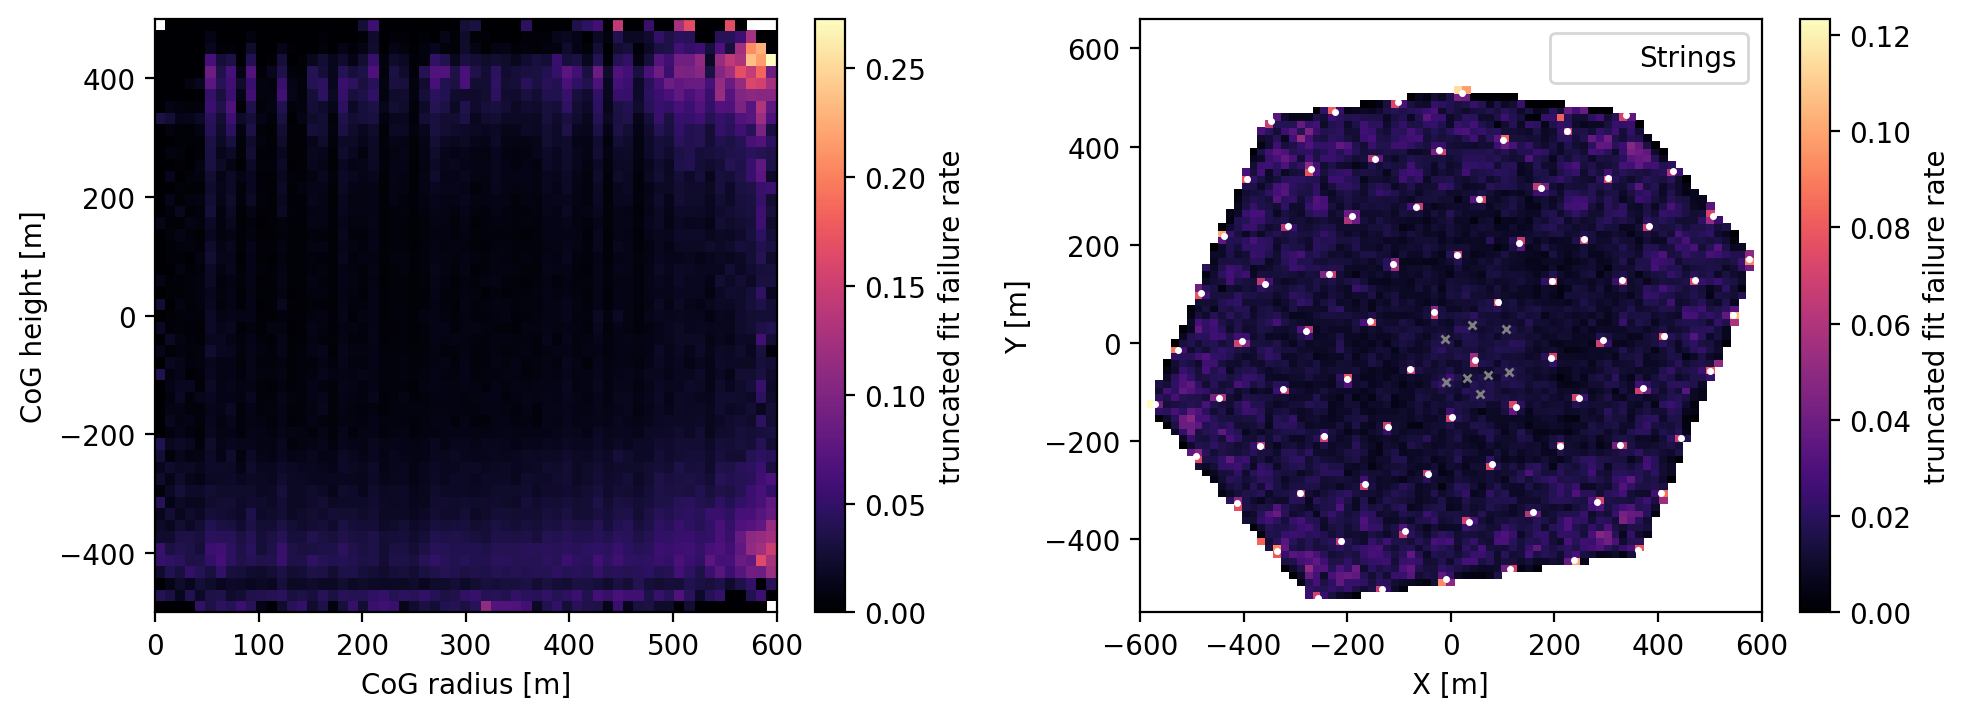

In [57]:
#clabel = 'Event count 21002+21124'
#geometry_template_plot(Redges,Zedges,count_hist[0],clabel,
#                      x_edges, y_edges, xy_map[0],clabel,"geom_counts_sim2019.png")

clabel = 'truncated fit failure rate'
geometry_template_plot(Redges,Zedges,(Hist_no_trunc[0]/Hist_with_trunc[0]),clabel,
                      x_edges, y_edges, (xy_map_truncfail[0]/xy_map_counts[0]),clabel, 
                       "trunc_fail_sim2019.png",
                       cmap = "magma",str_color="white")

### failure rate vs energy

In [4]:
edges = rana.create_log_bin_edges(20,10**9,100)
ctrs = rana.get_log_bin_centers(edges)

In [5]:
vs_E_hist,_ = np.histogram(BDT_results["MCPrimaryEnergy"], bins = edges)
failed_vs_E_hist,_ = np.histogram(truncfailed["MCPrimaryEnergy"], bins = edges)

In [57]:
#custom step function to include the last bin
def full_step(x_bins,y, label=None, color="black", alpha = 1, ax = None):
    if ax !=None:
        ax.step(x_bins[:-1],y, color=color, label=label, where = "post", alpha = alpha)
        ax.hlines(y[-1], x_bins[-2], x_bins[-1], color = color, alpha = alpha) 
    else:
        plt.step(x_bins[:-1],y, color=color, label=label, where = "post", alpha = alpha)
        plt.hlines(y[-1], x_bins[-2], x_bins[-1], color = color, alpha = alpha)

(0.0, 0.4)

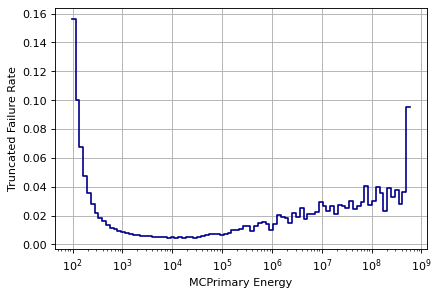

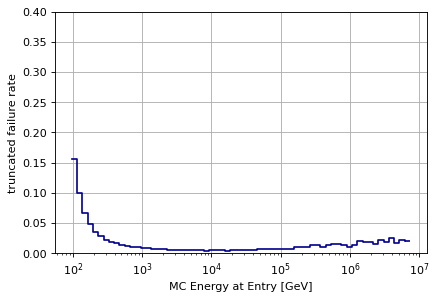

In [12]:
plt.figure(dpi = 80)
full_step(edges, failed_vs_E_hist/vs_E_hist, color="darkblue")
plt.xscale("log")
plt.grid()
plt.xlabel("MCPrimary Energy")
plt.ylabel("Truncated Failure Rate")

plt.figure(dpi = 80)
full_step(edges[:74], (failed_vs_E_hist/vs_E_hist)[:73], label = "flux ratio", color="darkblue")
plt.xscale("log")
plt.grid()
plt.xlabel("MC Energy at Entry [GeV]")
plt.ylabel("truncated failure rate")
plt.savefig(os.path.join(spacials_dir,"truncfail_vs_e_entry.png"))
plt.ylim(0,0.4)

### failure rate vs. zenith

In [14]:
#weighting events to get a reasonable zenith distribution.
generator_21124 = NeutrinoGenerator(NeutrinoFlavor='NuMu',NEvents = 500,
                                         FromEnergy=10000,
                                         ToEnergy = 500000000,
                                         InjectionMode='Surface',
                                         GammaIndex=1.0)*4605
generator_21002 = NeutrinoGenerator(NeutrinoFlavor="NuMu", NEvents = 200000,
                                         FromEnergy = 100,
                                         ToEnergy = 100000000,
                                         InjectionMode='Surface',
                                         GammaIndex=2.0)*9979

generators_2019 = generator_21124+generator_21002

In [15]:
def get_flux_weights(datadict, generator):
    flux  = np.ones(len(datadict))
    flux *= datadict["MCPrimaryEnergy"]**(-2)
    flux *= datadict["TIntProbW"]
    flux /= generator(datadict["MCPrimaryEnergy"],
                       datadict["MCPrimaryType"],
                       datadict["MCPrimaryCosZen"])
    return flux

In [16]:
fullflux = get_flux_weights(BDT_results, generators_2019)
#cleanflux = get_flux_weights(clean_BDT_results, generators_2019)
truncfailed_flux = get_flux_weights(truncfailed, generators_2019)

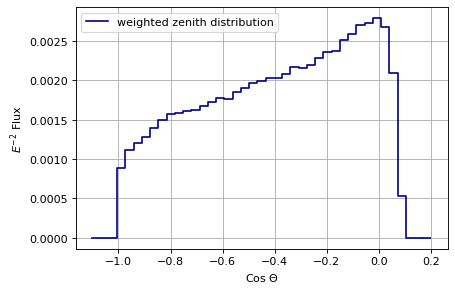

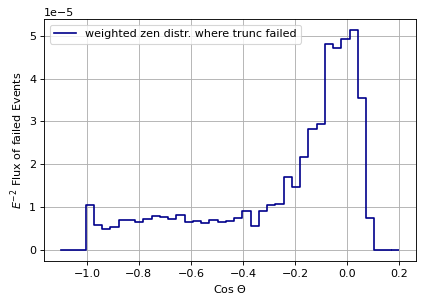

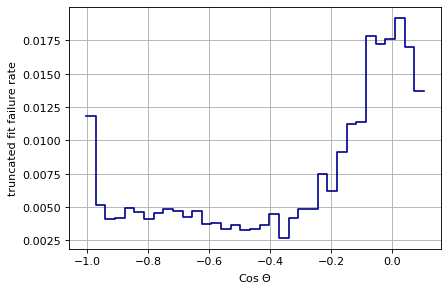

In [20]:
n_zenbins = 40
zenbins = rana.create_linear_bin_edges(-1.1,0.2,n_zenbins)
zenbinctrs = rana.get_linear_bin_centers(zenbins)

fullzenhist,_ = np.histogram(BDT_results["cos_zenith"],   bins =zenbins,  weights = fullflux)
failedzenhist,_ = np.histogram(truncfailed["cos_zenith"], bins = zenbins, weights = truncfailed_flux)
zenratio = failedzenhist/fullzenhist

color="darkblue"
dpi = 80
plt.figure(dpi = dpi)
full_step(zenbins, fullzenhist, label = "weighted zenith distribution",color=color)
plt.legend()
plt.grid()
plt.xlabel("Cos $\Theta$")
plt.ylabel("$E^{-2}$ Flux")
plt.savefig(os.path.join(spacials_dir,"zenith_flux.png"))

plt.figure(dpi = dpi)
full_step(zenbins,failedzenhist, label = "weighted zen distr. where trunc failed", color=color)
plt.legend()
plt.grid()
plt.xlabel("Cos $\Theta$")
plt.ylabel("$E^{-2}$ Flux of failed Events")
plt.savefig(os.path.join(spacials_dir,"zenith_failed_flux.png"))

plt.figure(dpi = dpi)
full_step(zenbins, zenratio, color=color)
plt.grid()
plt.xlabel("Cos $\Theta$")
plt.ylabel("truncated fit failure rate")
plt.savefig(os.path.join(spacials_dir,"truncated_zenith_failure_rate.png"))

Text(0, 0.5, 'Muon energy at entry [GeV]')

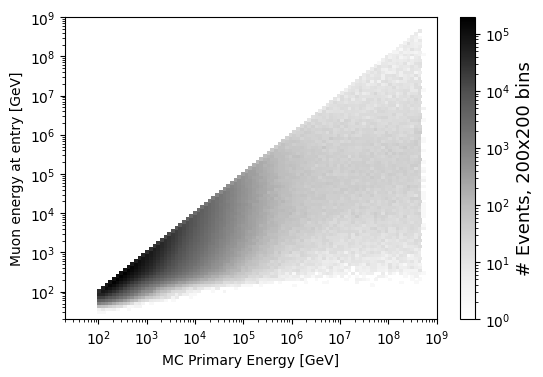

In [847]:
plt.figure(dpi = 100)
c1 = plt.pcolormesh(edges,edges, prime_vs_entry[0].T, cmap = "Greys", norm=colors.LogNorm(vmin = 1, vmax = np.max(prime_vs_entry[0])))
cbar = plt.colorbar(c1)
cbar.set_label('# Events, {}x{} bins'.format(nbins, nbins),size=size,rotation=90)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("MC Primary Energy [GeV]")
plt.ylabel("Muon energy at entry [GeV]")